# สำหรับภาษาไทย Colpali อาจจะไม่เหมาะลองใช้เป็น Cohere

In [1]:
!pip install -U cohere hnswlib -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.4/295.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 55.6 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
cohere_api = userdata.get('COHERE_API_KEY').strip()

In [3]:
from PIL import Image
from IPython.display import display, HTML
import requests
import cohere
import base64
import hnswlib
import os

In [4]:
co = cohere.ClientV2(
    api_key = cohere_api
)

# 01 Download dataset

### Cohere python
- source : <a href="https://github.com/cohere-ai/cohere-python">https://github.com/cohere-ai/cohere-python</a>

In [5]:
!git clone https://github.com/cohere-ai/cohere-developer-experience.git

Cloning into 'cohere-developer-experience'...
remote: Enumerating objects: 16941, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 16941 (delta 197), reused 142 (delta 142), pack-reused 16693 (from 3)
Receiving objects: 100% (16941/16941), 213.28 MiB | 27.82 MiB/s, done.
Resolving deltas: 100% (11001/11001), done.
Updating files: 100% (2444/2444), done.


In [6]:
cd cohere-developer-experience/notebooks/

/content/cohere-developer-experience/notebooks


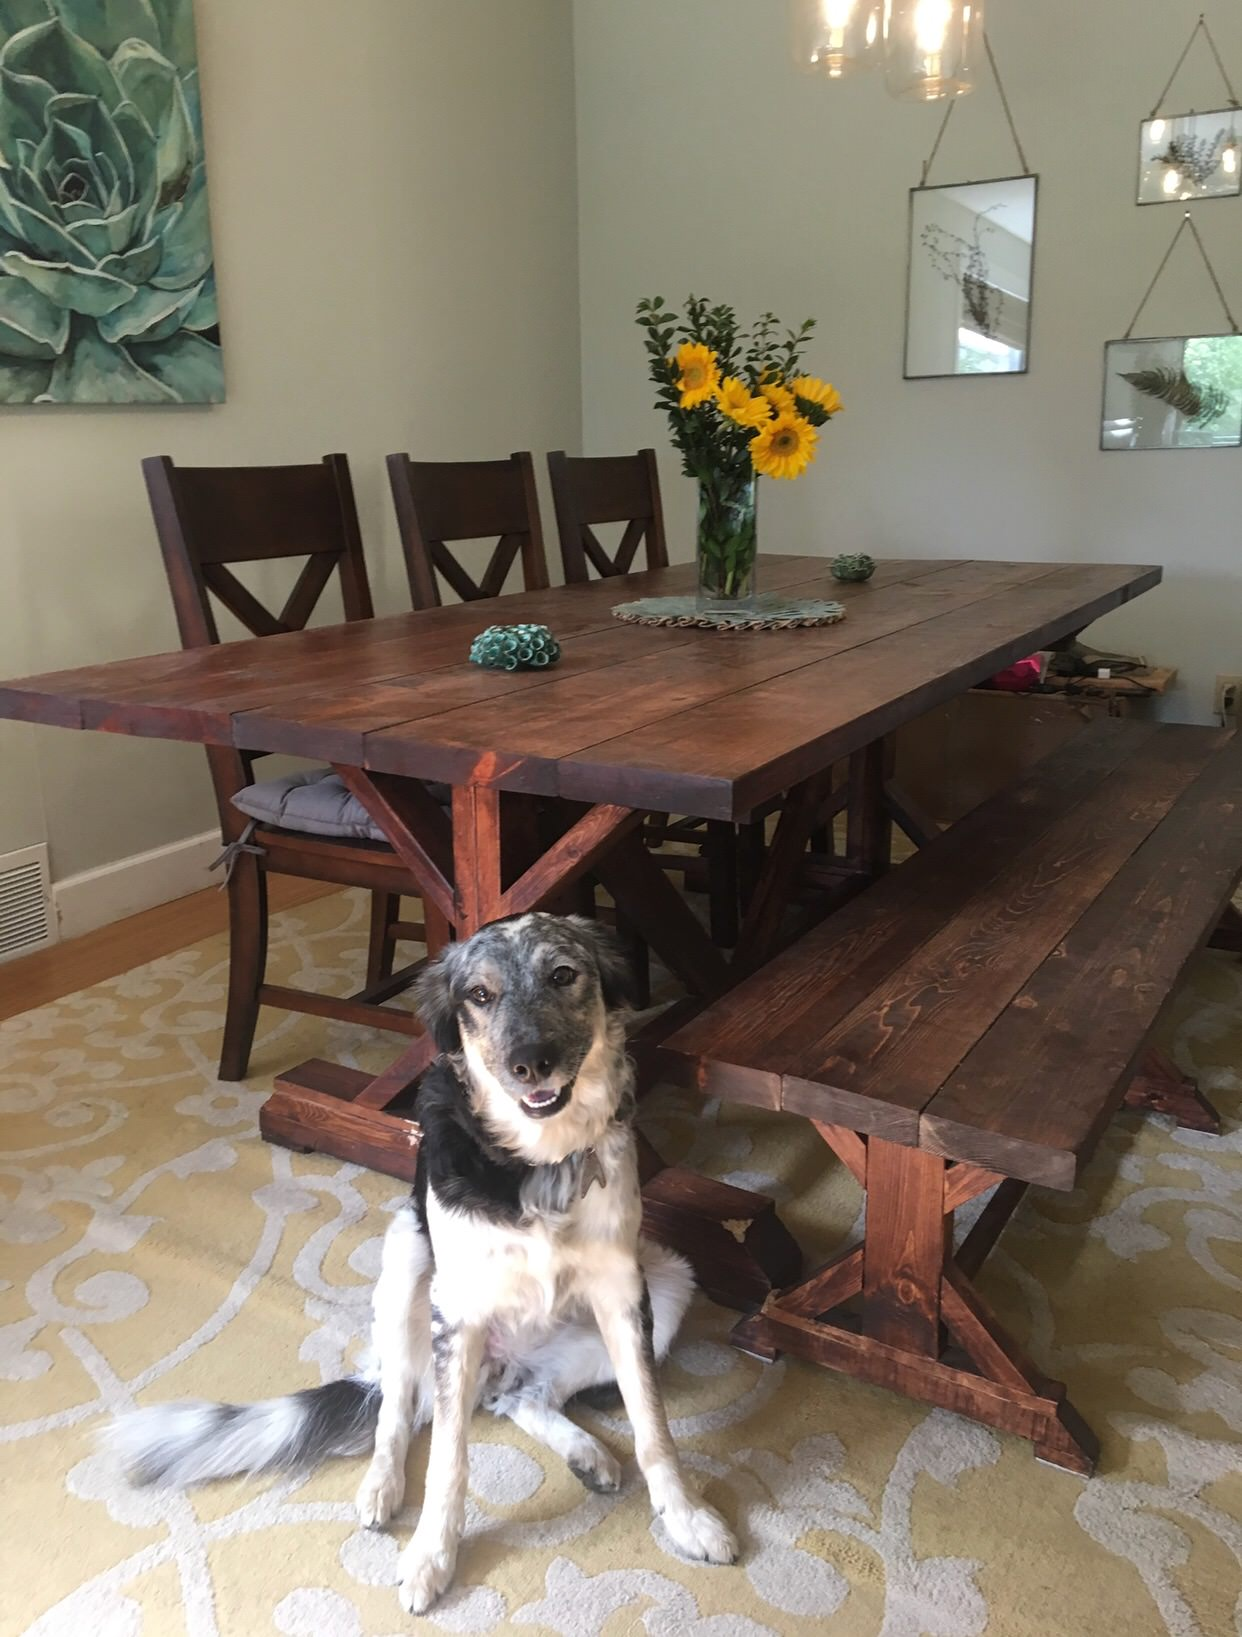

In [8]:
folder_path = "data/multimodal_semantic_search"
files = os.listdir(folder_path)

file_path = os.path.join(folder_path, files[1])
img = Image.open(file_path)
display(img)

# 02 Image embedding

In [9]:
def image_to_base64_data_url(image_path):
    with open(image_path, "rb") as f:
        enc_img = base64.b64encode(f.read()).decode("utf-8")
        enc_img = f"data:ima ge/jpeg;base64,{enc_img}"
    response = co.embed(
        model = "embed-v4.0",
        images = [enc_img],
        input_type = "image",
        embedding_types = ["float"],
    )
    return response

In [10]:
embeddings = []
file_paths = []
for file in files:
    file_path = os.path.join(folder_path,file)
    res = image_to_base64_data_url(file_path)
    file_paths.append(file_path)
    embeddings.append(res.embeddings.float[0])

In [11]:
print(str(embeddings[0][:10])[:-1]+", ...")

[-0.00709304, 0.032666326, 0.020397281, -0.021930913, 0.01318922, -0.02377127, -0.009316804, -0.012652449, -0.01318922, 0.042328194, ...


In [12]:
if embeddings:
    print(len(embeddings[0]))

1536


# 03 Cosine distance

In [13]:
index = hnswlib.Index(space="cosine", dim=1536)
index.init_index(max_elements = len(embeddings), ef_construction=512, M=64)
index.add_items(embeddings, list(range(len(embeddings))))

In [16]:
def retrieve_image(query):
    top_k = 5
    size  = (200,200)
    # Convert the query into embeddings
    query_emb = co.embed(
        texts = [query],
        model = "embed-v4.0",
        input_type = "search_query",
        embedding_types = ["float"],
    ).embeddings.float
    # Retrieve the initial results from your vector db
    res = index.knn_query(query_emb, k=top_k)
    doc_index = res[0][0]
    doc_scores = res[1][0]
    # Let's view the response image:
    print(f"The most relevant photo in the top {top_k} retreived images with a distance score of : {doc_scores[0]:.2f}")
    img = Image.open(file_paths[doc_index[0]])
    img_resized = img.resize(size)
    display(img_resized)
    # For the full list of images grabbed:
    print("-"*100)
    print("All top k images:")
    for x in range(0,len(doc_index)):
        print(f"Ranking of Revevance:{x+1} with a distance of: {doc_scores[x]:.2f}")
        img = Image.open(file_paths[doc_index[x]])
        img_resized = img.resize(size)
        display(img_resized)

# 04 Query

The most relevant photo in the top 5 retreived images with a distance score of : 0.60


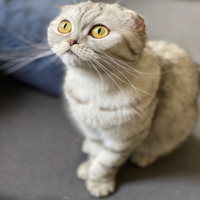

----------------------------------------------------------------------------------------------------
All top k images:
Ranking of Revevance:1 with a distance of: 0.60


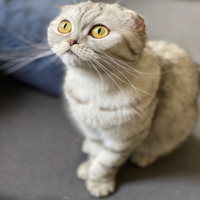

Ranking of Revevance:2 with a distance of: 0.65


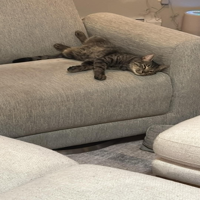

Ranking of Revevance:3 with a distance of: 0.65


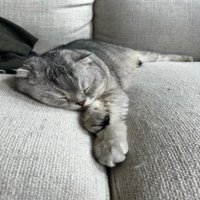

Ranking of Revevance:4 with a distance of: 0.67


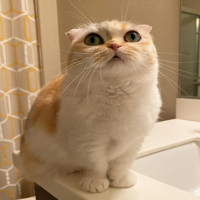

Ranking of Revevance:5 with a distance of: 0.71


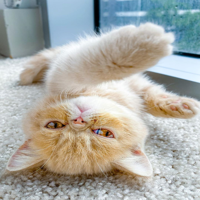

In [17]:
query = "แมวตัวฟูสีเทา"
retrieve_image(query)

The sample dataset also contains images from other domains such as ecommerce products and stock charts. Let's try a couple of queries to see how multimodal search can be useful in these domains.

[link text](https://)Here we send a query about ecommerce products, such as "Nike shoes", and return the top 2 images that match the query.

In [18]:
def retrieve_image_top_k(query, top_k=2):
    size = (200, 200)

    # Convert the query into embeddings
    query_emb = co.embed(
        texts=[query],
        model="embed-v4.0",
        input_type="search_query",
        embedding_types=["float"],
    ).embeddings.float

    # Retrieve the initial results from your vector db
    res = index.knn_query(query_emb, k=top_k)
    doc_index = res[0][0]
    doc_scores = res[1][0]

    # For the full list of images grabbed:
    print("-" * 100)
    print("All top k images:")
    for x in range(0, len(doc_index)):
        print(f"Ranking of Relevance:{x+1} with a distance of: {doc_scores[x]:.2f}")
        img = Image.open(file_paths[doc_index[x]])
        img_resized = img.resize(size)
        display(img_resized)

----------------------------------------------------------------------------------------------------
All top k images:
Ranking of Relevance:1 with a distance of: 0.73


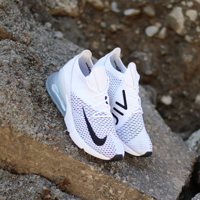

Ranking of Relevance:2 with a distance of: 0.73


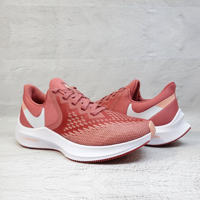

In [19]:
query = "รองเท้ายี่ห้อไนกี้"

retrieve_image_top_k(query)

----------------------------------------------------------------------------------------------------
All top k images:
Ranking of Relevance:1 with a distance of: 0.66


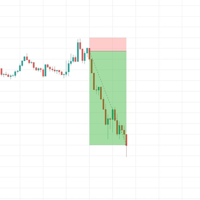

Ranking of Relevance:2 with a distance of: 0.72


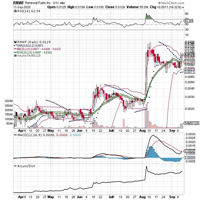

In [20]:
query = "กราฟการลงทุน"

retrieve_image_top_k(query)